# Optimize the Beale Function using Adam

* [D. Kingma, et. al., ADAM: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
* In addition to storing an exponentially decaying average of past squared gradients like Adadelta and RMSprop
* Adam also keeps an exponentially decaying average of past gradients, similar to momentum.
* Whereas momentum can be seen as a ball running down a slope, Adam behaves like a heavy ball with friction, which thus prefers flat minima in the error surface.

We compute the decaying averages of past and past squared gradients $m_{t}$ and $v_{t}$ respectively as follows:

$$\begin{align}
m_{t} &= \beta_{1} m_{t-1} + (1 - \beta_{1}) g_{t}\\
v_{t} &= \beta_{2} v_{t-1} + (1 - \beta_{2}) g_{t}^{2}
\end{align}$$

where $g_{t}$ is
$$ g_{t} = \frac{\partial \mathcal{L}(\mathbf{w}_{t})}{\partial \mathbf{w}_{t}} $$

* $m_{t}$: estimate of the first moment (the mean) of the gradients
* $v_{t}$: estimate of the second moment (the uncentered variance) of the gradients

* Bias correction

$$\begin{align}
\hat{m}_{t} &= \frac{m_{t}}{1 - \beta_{1}^{t}}\\
\hat{v}_{t} &= \frac{v_{t}}{1 - \beta_{2}^{t}}
\end{align}$$

* weight update

$$\mathbf{w}_{t+1} = \mathbf{w}_{t} - \frac{\eta}{\sqrt{\hat{v}_{t}} + \epsilon} \hat{m}_{t}$$

## Import

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm

## Beale function

$$ f(x, y) = (1.5 - x + xy)^{2} + (2.25 - x + xy^{2})^{2} + (2.625 - x +xy^{3})^{2}$$

* analytic solution (global minima)
  * $(x, y) = (3, 0.5)$

In [2]:
f = lambda x, y: (1.5 - x + x*y)**2 + (2.25 - x + x*y**2)**2 + (2.625 - x + x*y**3)**2

In [3]:
def gradients(x, y):
  """Gradient of Beale function.

  Args:
    x: x-dimension of inputs
    y: y-dimension of inputs

  Returns:
    grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
      dx: gradient of Beale function with respect to x-dimension of inputs
      dy: gradient of Beale function with respect to y-dimension of inputs
  """
  dx = 2. * ( (1.5 - x + x * y) * (y - 1) + \
                (2.25 - x + x * y**2) * (y**2 - 1) + \
                (2.625 - x + x * y**3) * (y**3 - 1) )
  dy = 2. * ( (1.5 - x + x * y) * x + \
              (2.25 - x + x * y**2) * 2. * x * y + \
              (2.625 - x + x * y**3) * 3. * x * y**2 )
  grads = np.array([dx, dy])
  return grads

In [4]:
minima = np.array([3., .5])
minima_ = minima.reshape(-1, 1)
print("minima (1x2 row vector shape): {}".format(minima))
print("minima (2x1 column vector shape):")
print(minima_)

minima (1x2 row vector shape): [3.  0.5]
minima (2x1 column vector shape):
[[3. ]
 [0.5]]


In [5]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

### 3D plot with minima

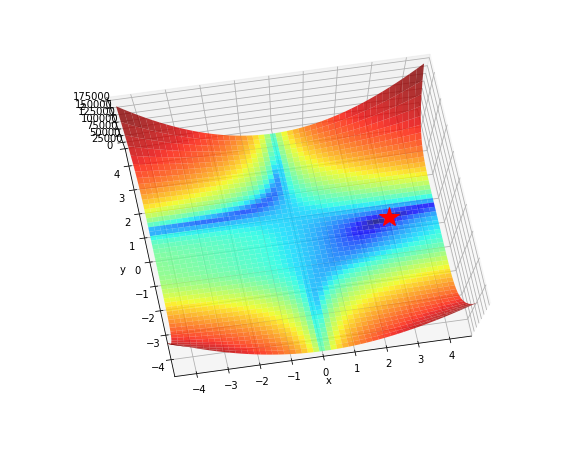

In [6]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

ax.plot_surface(x_mesh, y_mesh, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=20)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

### Contour plot with minima

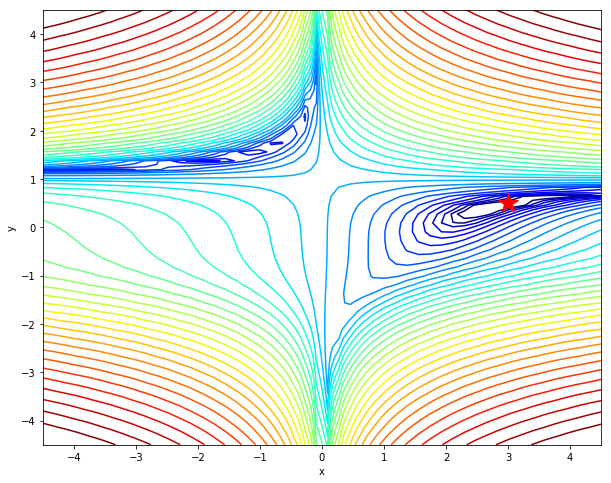

In [7]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()

## Build a Optimizer

In [8]:
class AdamOptimizer():
  def __init__(self, function, gradients, x_init=None, y_init=None,
               learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    self.f = function
    self.g = gradients
    scale = 3.0
    self.vars = np.zeros([2])
    if x_init is not None:
      self.vars[0] = x_init
    else:
      self.vars[0] = np.random.uniform(low=-scale, high=scale)
    if y_init is not None:
      self.vars[1] = y_init
    else:
      self.vars[1] = np.random.uniform(low=-scale, high=scale)
    print("x_init: {:.3f}".format(self.vars[0]))
    print("y_init: {:.3f}".format(self.vars[1]))
    
    self.lr = learning_rate
    self.grads_first_moment = np.zeros([2])
    self.grads_second_moment = np.zeros([2])
    self.beta1 = beta1
    self.beta2 = beta2
    self.epsilon = epsilon
    
    # for accumulation of loss and path (w, b)
    self.z_history = []
    self.x_history = []
    self.y_history = []
  
  
  def func(self, variables):
    """Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      z: Beale function value at (x, y)
    """
    x, y = variables
    z = self.f(x, y)
    return z
  
  def gradients(self, variables):
    """Gradient of Beale function.
    
    Args:
      variables: input data, shape: 1-rank Tensor (vector) np.array
        x: x-dimension of inputs
        y: y-dimension of inputs
      
    Returns:
      grads: [dx, dy], shape: 1-rank Tensor (vector) np.array
        dx: gradient of Beale function with respect to x-dimension of inputs
        dy: gradient of Beale function with respect to y-dimension of inputs
    """
    x, y = variables
    grads = self.g(x, y)
    return grads
  
  def weights_update(self, grads, time):
    """Weights update using Adam.
    
      g1 = beta1 * g1 + (1 - beta1) * grads
      g2 = beta2 * g2 + (1 - beta2) * g2
      g1_unbiased = g1 / (1 - beta1**time)
      g2_unbiased = g2 / (1 - beta2**time)
      w = w - lr * g1_unbiased / (sqrt(g2_unbiased) + epsilon)
    """
    self.grads_first_moment = self.beta1 * self.grads_first_moment + \
                              (1. - self.beta1) * grads
    self.grads_second_moment = self.beta2 * self.grads_second_moment + \
                              (1. - self.beta2) * grads**2
    
    self.grads_first_moment_unbiased = self.grads_first_moment / (1. - self.beta1**time)
    self.grads_second_moment_unbiased = self.grads_second_moment / (1. - self.beta2**time)
    
    self.vars = self.vars - self.lr * self.grads_first_moment_unbiased /(np.sqrt(self.grads_second_moment_unbiased) + self.epsilon)
      
  def history_update(self, z, x, y):
    """Accumulate all interesting variables
    """
    self.z_history.append(z)
    self.x_history.append(x)
    self.y_history.append(y)
    

  def train(self, max_steps):
    self.z_history = []
    self.x_history = []
    self.y_history = []
    pre_z = 0.0
    print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(0, self.func(self.vars), self.x, self.y))
    
    file = open('adam.txt', 'w')
    file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
    
    for step in range(max_steps):
      self.z = self.func(self.vars)
      self.history_update(self.z, self.x, self.y)

      self.grads = self.gradients(self.vars)
      self.weights_update(self.grads, step+1)
      file.write("{:.5f}  {:.5f}\n".format(self.x, self.y))
      
      if (step+1) % 100 == 0:
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}  dx: {:.5f}  dy: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y, self.dx, self.dy))
        
      if np.abs(pre_z - self.z) < 1e-7:
        print("Enough convergence")
        print("steps: {}  z: {:.6f}  x: {:.5f}  y: {:.5f}".format(step+1, self.func(self.vars), self.x, self.y))
        self.z = self.func(self.vars)
        self.history_update(self.z, self.x, self.y)
        break
        
      pre_z = self.z
    file.close()

    self.x_history = np.array(self.x_history)
    self.y_history = np.array(self.y_history)
    self.path = np.concatenate((np.expand_dims(self.x_history, 1), np.expand_dims(self.y_history, 1)), axis=1).T
    
    
  @property
  def x(self):
    return self.vars[0]
  
  @property
  def y(self):
    return self.vars[1]
  
  @property
  def dx(self):
    return self.grads[0]
  
  @property
  def dy(self):
    return self.grads[1]

### Create a `AdamOptimizer()` class

In [9]:
opt = AdamOptimizer(f, gradients, x_init=0.7, y_init=1.4, learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8)
#opt = AdamOptimizer(f, gradients, x_init=None, y_init=None, learning_rate=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8) # random initialize

x_init: 0.700
y_init: 1.400


### Training

In [10]:
%time
opt.train(1000)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 11 µs
steps: 0  z: 26.496662  x: 0.70000  y: 1.40000
steps: 100  z: 0.024316  x: 2.68040  y: 0.41601  dx: -0.26027  dy: 0.25021
steps: 200  z: 0.001374  x: 2.91190  y: 0.47705  dx: -0.02968  dy: -0.01318
steps: 300  z: 0.000086  x: 2.97707  y: 0.49420  dx: -0.00710  dy: -0.00253
steps: 400  z: 0.000004  x: 2.99522  y: 0.49880  dx: -0.00144  dy: -0.00051
Enough convergence
steps: 409  z: 0.000003  x: 2.99590  y: 0.49897


### Results

In [11]:
print("Global minima")
print("x*: {:.2f}  y*: {:.2f}".format(minima[0], minima[1]))
print("Solution using the gradient descent")
print("x: {:.4f}  y: {:.4f}".format(opt.x, opt.y))

Global minima
x*: 3.00  y*: 0.50
Solution using the gradient descent
x: 2.9959  y: 0.4990


### Beale function plot

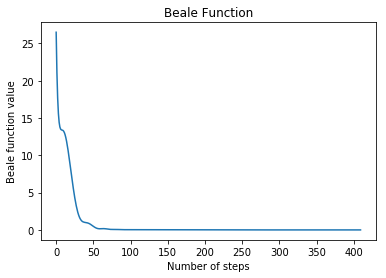

In [12]:
#Plot the Beale function
plt.title('Beale Function')
plt.xlabel('Number of steps')
plt.ylabel('Beale function value')
plt.plot(opt.z_history)
plt.show()

### Plot setting

In [13]:
# putting together our points to plot in a 3D plot
number_of_points = 50
margin = 4.5
x_min = 0. - margin
x_max = 0. + margin
y_min = 0. - margin
y_max = 0. + margin
x_points = np.linspace(x_min, x_max, number_of_points) 
y_points = np.linspace(y_min, y_max, number_of_points)
x_mesh, y_mesh = np.meshgrid(x_points, y_points)
z = np.array([f(xps, yps) for xps, yps in zip(x_mesh, y_mesh)])

### 3D plot with learning path

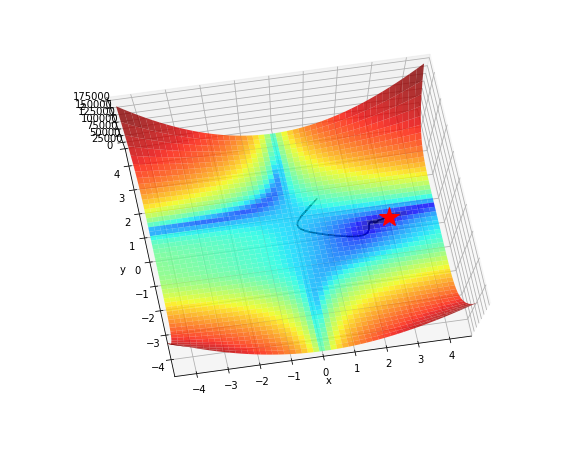

In [14]:
#%matplotlib inline
#%matplotlib notebook
#%pylab

path = opt.path

fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d', elev=80, azim=-100)

ax.plot_surface(x_mesh, y_mesh, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
ax.plot(*minima_, f(*minima_), 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], opt.func([*path[::,:-1]]),
          path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          opt.func([*path[::,1:]]) - opt.func([*path[::,:-1]]),
          color='k', length=1, normalize=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

#plt.draw()
plt.show()

### Contour plot with learning path

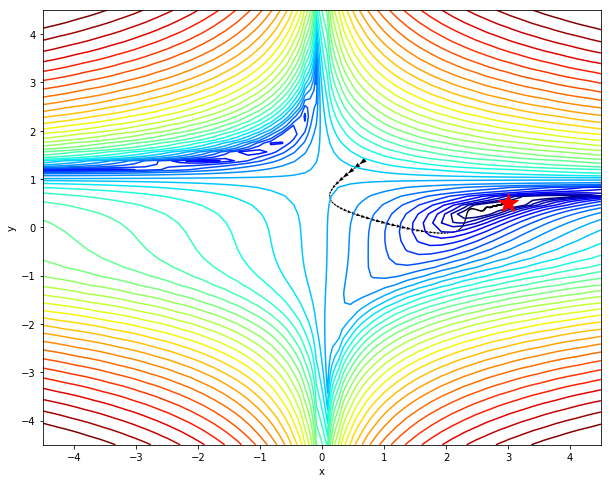

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.contour(x_mesh, y_mesh, z, levels=np.logspace(-.5, 5, 35), norm=LogNorm(), cmap=plt.cm.jet)
ax.plot(*minima, 'r*', markersize=20)
ax.quiver(path[0,:-1], path[1,:-1], path[0,1:]-path[0,:-1], path[1,1:]-path[1,:-1],
          scale_units='xy', angles='xy', scale=1, color='k')

ax.set_xlabel('x')
ax.set_ylabel('y')

ax.set_xlim((x_min, x_max))
ax.set_ylim((y_min, y_max))

plt.show()